In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pyproj
from convertbng.cutil import convert_bng, convert_etrs89_to_osgb36, convert_etrs89_to_ll, convert_osgb36_to_ll
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, MultiPoint, MultiPolygon
from descartes import PolygonPatch

from shapely.geometry import Polygon, MultiPolygon, box
from matplotlib.collections import PatchCollection

from scipy.spatial import Voronoi, voronoi_plot_2d

%matplotlib inline

/Users/sth/dev/lonlat_bng/venv/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/sth/dev/lonlat_bng/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    from http://stackoverflow.com/a/20678647/416626
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge
            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)


def plot_voronoi(lon, lat, ax, **kwargs):
    """ 
    More flexible Voronoi plotting
    kwargs are passed to ax.plot()
    returns computed voronoi object
    This is a bit of a black box tbh
    adapted from http://nbviewer.ipython.org/gist/wiso/6755034
    """
    vor = Voronoi(data[['projected_lon', 'projected_lat']])
    xy = np.dstack((lon, lat))[0]
    
    for simplex in vor.ridge_vertices:
        simplex = np.asarray(simplex)
        if np.all(simplex >= 0):
            ax.plot(vor.vertices[simplex, 0], vor.vertices[simplex, 1], **kwargs)
    center = xy.mean(axis=0)
    for pointidx, simplex in zip(vor.ridge_points, vor.ridge_vertices):
        simplex = np.asarray(simplex)
        if np.any(simplex < 0):
            i = simplex[simplex >= 0][0]
            t = xy[pointidx[1]] - xy[pointidx[0]]
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])
            midpoint = xy[pointidx].mean(axis=0)
            far_point = vor.vertices[i] + \
            np.sign(np.dot(midpoint - center, n)) * n * 10000000
            vor.complete_regions, vor.complete_vertices = voronoi_finite_polygons_2d(vor)
            #  this plots the far points - maybe consider a dashed line
            ax.plot(
                [vor.vertices[i, 0], far_point[0]],
                [vor.vertices[i, 1], far_point[1]],
                **kwargs)
    return vor

In [3]:
from matplotlib import rc
rc('font', **{'family':'sans-serif',
    'sans-serif':['Helvetica'],
    'monospace': ['Inconsolata'],
    'serif': ['Helvetica']})
rc('text', **{'usetex': True})
rc('text', **{'latex.preamble': '\usepackage{sfmath}'})

In [4]:
# Ordnance Survey test values, ETRS89 x, y
etrs89_e = [331439.16, 362174.408, 151874.984, 339824.598, 241030.731, 599345.196,
                 357359.683, 389448.042, 319092.329, 525643.491, 397061.069, 256247.486,
                 266961.481, 244687.517, 227685.882, 562079.805, 422143.679, 170277.189,
                 530526.413, 247865.448, 247865.718, 167542.805, 292090.289, 424539.719,
                 639720.224, 474237.874, 453904.269, 438614.045, 250265.789, 449719.403,
                 440623.592, 299624.627, 91400.000, 9500.003, 71622.45, 180766.824, 261500.000,
                 395898.578, 421200.000, 330300.000, 337800.000, 334100.000]
etrs89_n = [431992.943, 170056.5,
                                966535.331,
                                556102.504,
                                220409.858,
                                225801.485,
                                383364.152,
                                261989.271,
                                671010.63,
                                470775.61,
                                805408.146,
                                664760.292,
                                846233.646,
                                495324.611,
                                468918.331,
                                319862.042,
                                433891.207,
                                11652.895,
                                178467.043,
                                393566.264,
                                393568.938,
                                797124.153,
                                168081.281,
                                565080.533,
                                169645.824,
                                262125.333,
                                340910.743,
                                114871.192,
                                62095.883,
                                75415.594,
                                1107930.781,
                                967256.596,
                                11400.000,
                                899499.996,
                                938567.303,
                                1029654.639,
                                1025500.000,
                                1138780.346,
                                1072200.000,
                                1017400.000,
                                981800.000,
                                982100.000]

In [5]:
# Ordnance Survey test values, ETRS89 lon, lat
etrs89_lon = [
    -3.0404549,
     -2.54407618,
     -6.26091467,
     -2.93827742,
     -4.30852477,
     0.89724327,
     -2.64049321,
     -2.15458614,
     -3.2947922,
     -0.07773132,
     -2.04856032,
     -4.29649018,
     -4.21926404,
     -4.38849118,
     -4.63452169,
     0.40153548,
     -1.66379168,
     -5.20304611,
     -0.11992556,
     -4.28918069,
     -4.28917792,
     -5.82836702,
     -3.55128349,
     -1.61657684,
     1.44454731,
     -0.91248957,
     -1.19747657,
     -1.45051434,
     -4.10864564,
     -1.29782277,
     -1.2748691,
     -3.72631026,
     -6.29977753,
     -8.57854474,
     -7.59255577,
     -5.8279935,
     -4.41757681,
     -2.07382823,
     -1.62516965,
     -3.21454004,
     -3.07392607,
     -3.13788291
]

etrs89_lat = [
    53.77911025,
     51.42754743,
     58.51560462,
     54.89542346,
     51.85890897,
     51.89436637,
     53.34480281,
     52.25529381,
     55.92478316,
     54.11685144,
     57.13902611,
     55.85400002,
     57.48625099,
     54.32919541,
     54.08666318,
     52.75136687,
     53.8002152,
     49.96006138,
     51.48936564,
     53.41628516,
     53.41630925,
     57.00606785,
     51.4007822,
     54.97912283,
     51.37447026,
     52.25160951,
     52.9621911,
     50.93127938,
     50.43885825,
     50.57563665,
     59.85409974,
     58.58120563,
     49.92226394,
     57.81351942,
     58.2126235,
     59.09671707,
     59.09335126,
     60.13308136,
     59.5347087,
     59.03743964,
     58.71893818,
     58.72108386
]

In [6]:
# ordnance survey result values, OSGB36 x, y

osgb36_test_e = [331534.552, 362269.979, 151968.641, 339921.133, 241124.573, 599445.578,
                 357455.831, 389544.178, 319188.423, 525745.658, 397160.479, 256340.914,
                 267056.756, 244780.625, 227778.318, 562180.535, 422242.174, 170370.706,
                 530624.963, 247958.959, 247959.229, 167634.19, 292184.858, 424639.343,
                 639821.823, 474335.957, 454002.822, 438710.908, 250359.798, 449816.359,
                 440725.061, 299721.879, 91492.135, 9587.897, 71713.12, 180862.449, 261596.767,
                 395999.656, 421300.513, 330398.311, 337898.195, 334198.101]

osgb36_test_n = [431920.792,
                                169978.688,
                                966483.777,
                                556034.759,
                                220332.638,
                                225722.824,
                                383290.434,
                                261912.151,
                                670947.532,
                                470703.211,
                                805349.734,
                                664697.266,
                                846176.969,
                                495254.884,
                                468847.386,
                                319784.993,
                                433818.699,
                                11572.404,
                                178388.461,
                                393492.906,
                                393495.58,
                                797067.142,
                                168003.462,
                                565012.7,
                                169565.856,
                                262047.752,
                                340834.941,
                                114792.248,
                                62016.567,
                                75335.859,
                                1107878.445,
                                967202.99,
                                11318.801,
                                899448.993,
                                938516.401,
                                1029604.111,
                                1025447.599,
                                1138728.948,
                                1072147.236,
                                1017347.013,
                                981746.359,
                                982046.419]

In [7]:
# define some CRS
etrs89 = pyproj.Proj(init='epsg:4258')
wgs84 = pyproj.Proj(init='epsg:4326')
osgb36 = pyproj.Proj(init='epsg:27700')
# include grid shifts
osgb36_ostn02 = pyproj.Proj("+init=EPSG:27700 +nadgrids=OSTN02_NTv2.gsb")

In [8]:
# convert to BNG (OSGB36) using pyproj and convertbng

# from etrs89 x, y to osgb36 e, n
convertbng_res_e, convertbng_res_n = convert_etrs89_to_osgb36(etrs89_e, etrs89_n)

# from osgb36 e, n to WGS84 lon, lat 
convertbng_res_lon, convertbng_res_lat = convert_osgb36_to_ll(convertbng_res_e, convertbng_res_n)

pyproj_res_e, pyproj_res_n = pyproj.transform(etrs89, osgb36, etrs89_lon, etrs89_lat)

In [9]:
df_plot = pd.DataFrame({
        'lons': convertbng_res_lon,
        'lats': convertbng_res_lat
    })

In [10]:
df_plot

lats      lons
0   53.779110 -3.040455
1   51.427547 -2.544076
2   58.515605 -6.260915
3   54.895423 -2.938277
4   51.858909 -4.308525
5   51.894366  0.897243
6   53.344803 -2.640493
7   52.255294 -2.154586
8   55.924783 -3.294792
9   54.116851 -0.077731
10  57.139026 -2.048560
11  55.854000 -4.296490
12  57.486251 -4.219264
13  54.329195 -4.388491
14  54.086663 -4.634522
15  52.751367  0.401535
16  53.800215 -1.663792
17  49.960061 -5.203046
18  51.489366 -0.119926
19  53.416285 -4.289181
20  53.416309 -4.289178
21  57.006068 -5.828367
22  51.400782 -3.551283
23  54.979123 -1.616577
24  51.374470  1.444547
25  52.251610 -0.912490
26  52.962191 -1.197477
27  50.931279 -1.450514
28  50.438858 -4.108646
29  50.575637 -1.297823
30  59.854100 -1.274869
31  58.581206 -3.726310
32  49.922264 -6.299778
33  57.813519 -8.578545
34  58.212623 -7.592556
35  59.096717 -5.827993
36  59.093351 -4.417577
37  60.133081 -2.073828
38  59.534709 -1.625170
39  59.037440 -3.214540
40  58.718938 -3.073926
41  58.721084 -3.137883

In [11]:
# instantiate a map
from itertools import chain

bds = [-6.108398, 49.61071, 1.669922, 58.972667]
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

minx, miny, maxx, maxy = bds
w, h = maxx - minx, maxy - miny

In [12]:
# add a basemap and a small additional extent
m = Basemap(
    projection='merc',
    ellps = 'WGS84',
    llcrnrlon=minx - 0.2 * w,
    llcrnrlat=miny - 0.2 * h,
    urcrnrlon=maxx + 0.2 * w,
    urcrnrlat=maxy + 0.2 * h,
    lat_ts=0,
    resolution='h')

In [13]:
df_plot['projected_lon'], df_plot['projected_lat'] = m(*(df_plot["lons"].values, df_plot["lats"].values))

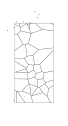

In [32]:
# create a new matplotlib figure and axes instance
fig = plt.figure(figsize=(1, 2))
ax = fig.add_subplot(111, axisbg='none')

# m.drawcoastlines(linewidth=0.3)
m.drawmapboundary()



# generate voronoi decomposition
vor = Voronoi(df_plot[['projected_lon', 'projected_lat']])
# get finite cells
vor.complete_regions, vor.complete_vertices = voronoi_finite_polygons_2d(vor)
# create square polygon of map extent
clip = box(*(chain(m(bds[0], bds[1]), m(bds[2], bds[3]))))
# clip Voronoi cells to map extent by intersecting with box
clipped = [clip.intersection(poly) for poly in
           (Polygon(pol) for pol in (vor.complete_vertices[region] for region in vor.complete_regions))]


patches = [PolygonPatch(pol) for pol in clipped if type(pol) == Polygon]
# we can specify a normalize instance (area?) and a colour map here
pc = PatchCollection(patches, match_original=False, alpha=0.75, color='#000000', lw=.2, zorder=5)
pc.set_facecolor('#ffffff')
# uncomment to add the filled voronoi tesselation
ax.add_collection(pc)


# set axes limits to basemap's coordinate reference system 
min_x, min_y = m(minx, miny)
max_x, max_y = m(maxx, maxy)
corr_w, corr_h = max_x - min_x, max_y - min_y
ax.set_xlim(min_x - 0.2 * corr_w, max_x + 0.2 * corr_w)
ax.set_ylim(min_y - 0.2 * corr_h, max_y + 0.2 * corr_h)
# square up axes and basemap
ax.set_aspect(1)
# buffer units are translated to metres by Basemap
patches = [PolygonPatch(Point(m(lon, lat)).buffer(5000),
                        fc='#cc00cc', ec='#555555', alpha=0.75, zorder=4)
           for lon, lat in zip(df_plot.lons, df_plot.lats)]

ax.add_collection(PatchCollection(patches, match_original=True))
ax.axis('off')
plt.savefig('points.png', dpi=150, alpha=True, transparent=True)
plt.show()

In [23]:
type(clipped[0])

shapely.geometry.polygon.Polygon

In [8]:
df = pd.DataFrame(
    {
        "OS_e": osgb36_test_e,
        "OS_n": osgb36_test_n,
        "convertbng_e": convertbng_res_e,
        "convertbng_n": convertbng_res_n,
        "pyproj_e": pyproj_res_e,
        "pyproj_n": pyproj_res_n
    })


# calculate differences
df['convertbng_e_diff'] = df.OS_e - df.convertbng_e
df['convertbng_n_diff'] = df.OS_n - df.convertbng_n

df['pyproj_e_diff'] = df.OS_e - df.pyproj_e
df['pyproj_n_diff'] = df.OS_n - df.pyproj_n

df.head()

OS_e        OS_n  convertbng_e  convertbng_n       pyproj_e  \
0  331534.552  431920.792    331534.552    431920.791  331534.550305   
1  362269.979  169978.688    362269.979    169978.688  362269.980162   
2  151968.641  966483.777    151968.641    966483.889  151968.642709   
3  339921.133  556034.759    339921.132    556034.765  339921.132563   
4  241124.573  220332.638    241124.573    220332.638  241124.572998   

        pyproj_n  convertbng_e_diff  convertbng_n_diff  pyproj_e_diff  \
0  431920.790149       5.820766e-11              0.001       0.001695   
1  169978.683970       0.000000e+00              0.000      -0.001162   
2  966483.888993       0.000000e+00             -0.112      -0.001709   
3  556034.764894       1.000000e-03             -0.006       0.000437   
4  220332.636264       0.000000e+00              0.000       0.000002   

   pyproj_n_diff  
0       0.001851  
1       0.004030  
2      -0.111993  
3      -0.005894  
4       0.001736

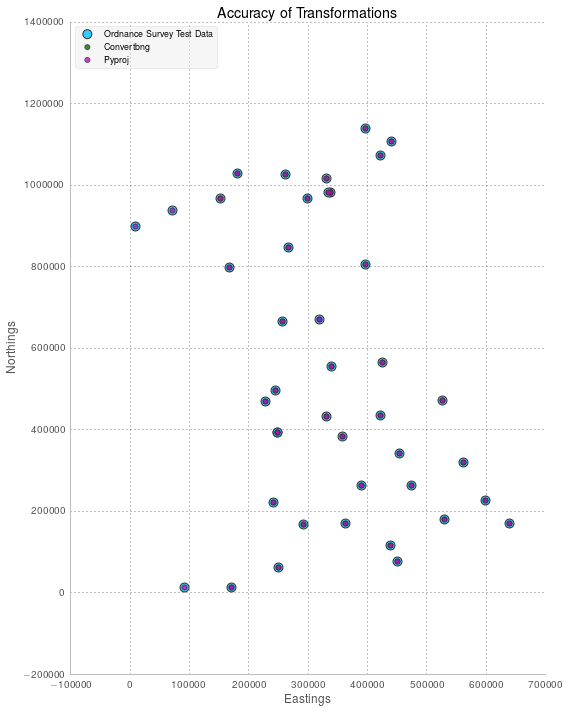

In [96]:
# plot results

plt.clf()
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(111, axisbg='none')
orig = plt.scatter(
    df['OS_e'],
    df['OS_n'],
    color='#33CCFF',
    edgecolor='#333333',
    marker='o',
    lw=1,
    s=80,
    alpha=1.0)

convertbng = plt.scatter(
    df['convertbng_e'],
    df['convertbng_n'],
    marker='o',
    color='#006600',
    edgecolor='#333333',
    lw=1,
    s=25,
    alpha=0.75)

pyproj = plt.scatter(
    df['pyproj_e'],
    df['pyproj_n'],
    marker='o',
    color='#CC00CC',
    edgecolor='#333333',
    lw=1,
    s=25,
    alpha=0.75)

ax.set_xlabel('Eastings')
ax.set_ylabel('Northings')
plt.title("Accuracy of Transformations")
leg = plt.legend(
    (orig, convertbng, pyproj),
    ('Ordnance Survey Test Data',
    "Convertbng",
   'Pyproj'),
    loc='upper left',
    scatterpoints=1,
    fontsize=9)
leg.get_frame().set_alpha(0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
ax.grid(b=None)
plt.savefig('test_data.png', format="png", bbox_inches='tight', alpha=True, transparent=True, dpi=300)
plt.show()

In [72]:
# put ostn02 grid shift file in here
pyproj
print pyproj.pyproj_datadir

/Users/sth/dev/lonlat_bng/venv/lib/python2.7/site-packages/pyproj/data


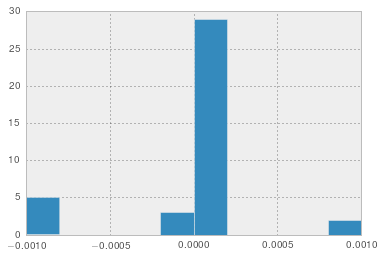

In [9]:
df['convertbng_e_diff'].hist()

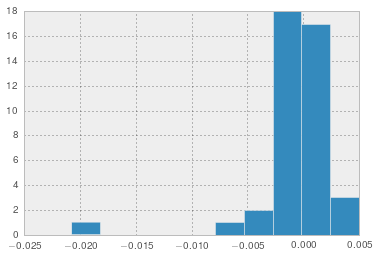

In [10]:
df['pyproj_e_diff'].hist()

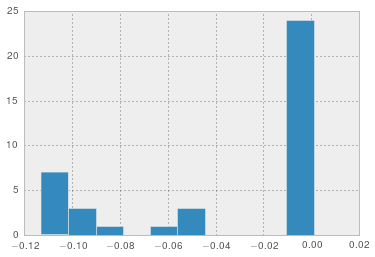

In [11]:
df['convertbng_n_diff'].hist()

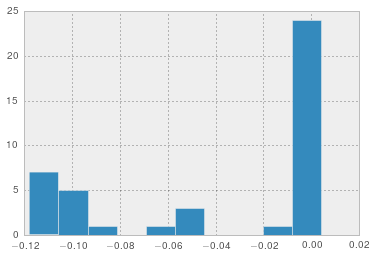

In [12]:
df['pyproj_n_diff'].hist()

In [106]:
df

OS_e         OS_n  convertbng_e  convertbng_n       pyproj_e  \
0   331534.552   431920.792    331534.552    431920.791  331534.774663   
1   362269.979   169978.688    362269.979    169978.688  362269.948057   
2   151968.641   966483.777    151968.641    966483.889  151967.507879   
3   339921.133   556034.759    339921.132    556034.765  339920.907833   
4   241124.573   220332.638    241124.573    220332.638  241123.036187   
5   599445.578   225722.824    599445.578    225722.824  599447.608443   
6   357455.831   383290.434    357455.831    383290.434  357455.855556   
7   389544.178   261912.151    389544.178    261912.151  389544.680553   
8   319188.423   670947.532    319188.424    670947.588  319188.476915   
9   525745.658   470703.211    525745.658    470703.211  525744.761695   
10  397160.479   805349.734    397160.479    805349.836  397159.946751   
11  256340.914   664697.266    256340.914    664697.321  256341.818432   
12  267056.756   846176.969    267056.756    846177.079  267056.810841   
13  244780.625   495254.884    244780.625    495254.884  244780.894318   
14  227778.318   468847.386    227778.318    468847.386  227778.679594   
15  562180.535   319784.993    562180.535    319784.992  562181.531714   
16  422242.174   433818.699    422242.174    433818.700  422241.874585   
17  170370.706    11572.404    170370.706     11572.403  170366.823437   
18  530624.963   178388.461    530624.963    178388.461  530626.708705   
19  247958.959   393492.906    247958.960    393492.905  247958.550442   
20  247959.229   393495.580    247959.230    393495.580  247958.820527   
21  167634.190   797067.142    167634.190    797067.241  167635.106740   
22  292184.858   168003.462    292184.858    168003.462  292183.852940   
23  424639.343   565012.700    424639.344    565012.710  424638.472167   
24  639821.823   169565.856    639821.823    169565.856  639823.549751   
25  474335.957   262047.752    474335.957    262047.752  474336.902652   
26  454002.822   340834.941    454002.822    340834.941  454003.017797   
27  438710.908   114792.248    438710.908    114792.249  438711.527215   
28  250359.798    62016.567    250359.798     62016.566  250357.821188   
29  449816.359    75335.859    449816.359     75335.859  449817.050544   
30  440725.061  1107878.445    440725.060   1107878.512  440724.861338   
31  299721.879   967202.990    299721.880    967203.103  299721.357844   
32   91492.135    11318.801           NaN           NaN   91487.427488   
33    9587.897   899448.993           NaN           NaN    9588.182533   
34   71713.120   938516.401           NaN           NaN   71712.568322   
35  180862.449  1029604.111    180862.449   1029604.211  180860.426831   
36  261596.767  1025447.599    261596.767   1025447.700  261595.878513   
37  395999.656  1138728.948    395999.656   1138728.997  395998.704721   
38  421300.513  1072147.236    421300.513   1072147.320  421300.583564   
39  330398.311  1017347.013    330398.311   1017347.117  330397.798101   
40  337898.195   981746.359    337898.195    981746.470  337897.871262   
41  334198.101   982046.419    334198.101    982046.531  334197.767473   

        pyproj_n  convertbng_e_diff  convertbng_n_diff  pyproj_e_diff  \
0   4.319224e+05       5.820766e-11       1.000000e-03      -0.222663   
1   1.699785e+05       0.000000e+00       0.000000e+00       0.030943   
2   9.664809e+05       0.000000e+00      -1.120000e-01       1.133121   
3   5.560355e+05       1.000000e-03      -6.000000e-03       0.225167   
4   2.203337e+05       0.000000e+00       0.000000e+00       1.536813   
5   2.257241e+05       0.000000e+00       0.000000e+00      -2.030443   
6   3.832922e+05       0.000000e+00       0.000000e+00      -0.024556   
7   2.619137e+05       0.000000e+00       0.000000e+00      -0.502553   
8   6.709470e+05      -1.000000e-03      -5.600000e-02      -0.053915   
9   4.707055e+05       0.000000e+00       0.000000e+00       0.896305   
10  8.053481e+05       0